Reference: https://github.com/Eligijus112/Vilnius-weather-LSTM

### Get Data

In [ ]:
%%bash
if [ ! -d '/content/data' ]; then
  git clone https://gitlab.com/Dimu_1020/big_data_final '/content/data'
  cd '/content/data'
else
  echo "Dataset already downloaded in '/content/data'"
fi

Cloning into '/content/data'...


### Import dependencies

In [ ]:
# pip install pyspark

In [ ]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

# pyspark related
# pip install pyspark
# import pyspark
# from pyspark.sql.functions import split, explode, to_timestamp, from_unixtime, from_utc_timestamp
# from pyspark import SparkConf, SparkContext,SQLContext
# from pyspark.sql import SparkSession
# from pyspark.sql.types import IntegerType,ArrayType,StringType,DoubleType
# from pyspark.sql.functions import *
# from pyspark.sql import Window
# # from pyspark.ml.feature import StandardScaler
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import VectorAssembler
# #from ts.flint import FlintContext
# sc = SparkContext.getOrCreate()
# sqlContext = SQLContext(sc)

In [ ]:
d = pd.read_csv('data/weather.csv')

In [ ]:
# Converting the dt column to datetime object 
d['dt'] = [datetime.datetime.utcfromtimestamp(x) for x in d['dt']]

# Sorting by the date 
d.sort_values('dt', inplace=True)

In [ ]:
d['year'] = [x.year for x in d['dt']]
d['month'] = [x.month for x in d['dt']]
d = d[['year','month', 'temp']]
d

,year,month,temp
0,1990,1,-7.52
1,1990,1,-7.56
2,1990,1,-7.67
3,1990,1,-7.74
4,1990,1,-7.66
...,...,...,...
294222,2020,11,-0.85
294223,2020,11,-0.85
294224,2020,11,-0.85
294225,2020,11,-0.67


In [ ]:
d = d.groupby(['year', 'month']).mean()

In [ ]:
d = d.reset_index()
d

,year,month,temp
0,1990,1,0.024691
1,1990,2,3.160432
2,1990,3,4.269197
3,1990,4,7.898867
4,1990,5,11.799455
...,...,...,...
366,2020,7,17.516312
367,2020,8,18.118543
368,2020,9,14.446079
369,2020,10,9.933199


In [ ]:
d.to_csv('temp_monthly', index=False)

In [ ]:
temp = d.temp
temp

0       0.024691
1       3.160432
2       4.269197
3       7.898867
4      11.799455
         ...    
366    17.516312
367    18.118543
368    14.446079
369     9.933199
370     4.000133
Name: temp, Length: 371, dtype: float64

## Data Cleaning

### Convert into rdd

In [ ]:
spark = SparkSession.builder.appName("DataFrame").getOrCreate()
path_to_file = 'data/weather.csv'
df = spark.read.csv(path_to_file, header=True)
df.show()

+---------+--------------------+--------+----------------+---------+---------+-----+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+-------------------+------------+
|       dt|              dt_iso|timezone|       city_name|      lat|      lon| temp|feels_like|temp_min|temp_max|pressure|sea_level|grnd_level|humidity|wind_speed|wind_deg|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|weather_description|weather_icon|
+---------+--------------------+--------+----------------+---------+---------+-----+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+-------------------+------------+
|631152000|1990-01-01 00:00:...|    7200|Vilnius TV Tower|54.687137|25.214648|-7.52|    -11.92|   -7.74|    -7.4|    1032|     null|      null|      87|         2|     180|   null| 

### Get datetime

In [ ]:
# convert to datestamp
spark.conf.set('spark.sql.session.timeZone', 'UTC')
df = df.withColumn("dt",from_unixtime(unix_timestamp(col("dt_iso"),"yyyy-MM-dd HH:mm:ss '+0000 UTC'"),'yyyy-MM-dd HH:mm:ss').cast("timestamp"))
# Sorting by the date 
df = df.sort(asc("dt"))
df.show()

KeyboardInterrupt: ignored

In [ ]:
# Listing the min and the max dates
first = df.agg({'dt': "min"}).collect()[0][0] 
last = df.agg({'dt': "max"}).collect()[0][0]
print(f"First date {first}")
print(f"Most recent date {last}")

### Get date

In [ ]:
df = df.withColumn("date",to_date("dt_iso"))
df.show()

### Select Features

In [ ]:
features = ['temp', 'pressure', 'wind_speed']
data_col = ['dt', 'date'] + features

### Get Hourly Data

In [ ]:
# Aggregating to hourly level
df_data = df.select(data_col).withColumn("temp", avg("temp").over(Window.partitionBy("dt"))) \
                   .withColumn("pressure", avg("pressure").over(Window.partitionBy("dt"))) \
                   .withColumn("wind_speed", avg("wind_speed").over(Window.partitionBy("dt")))
df_data.show()
# df.select(['dt']+features).groupBy(df.dt).avg().collect()

In [ ]:
df = df_data.select(['dt', 'temp'])

In [ ]:
df_arima = df.toPandas()
df_arima

In [ ]:
df_arima.temp[:40000]

### Final Dataset

## Data Modeling

#### Arima

In [ ]:
!pip install pmdarima


     |████████████████████████████████| 1.4 MB 7.1 MB/s 
     |████████████████████████████████| 9.8 MB 24.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.arima import auto_arima

In [ ]:
temp = df_arima.temp

In [ ]:
temp = d.temp

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(temp[:100000])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.288897
p-value: 0.000000


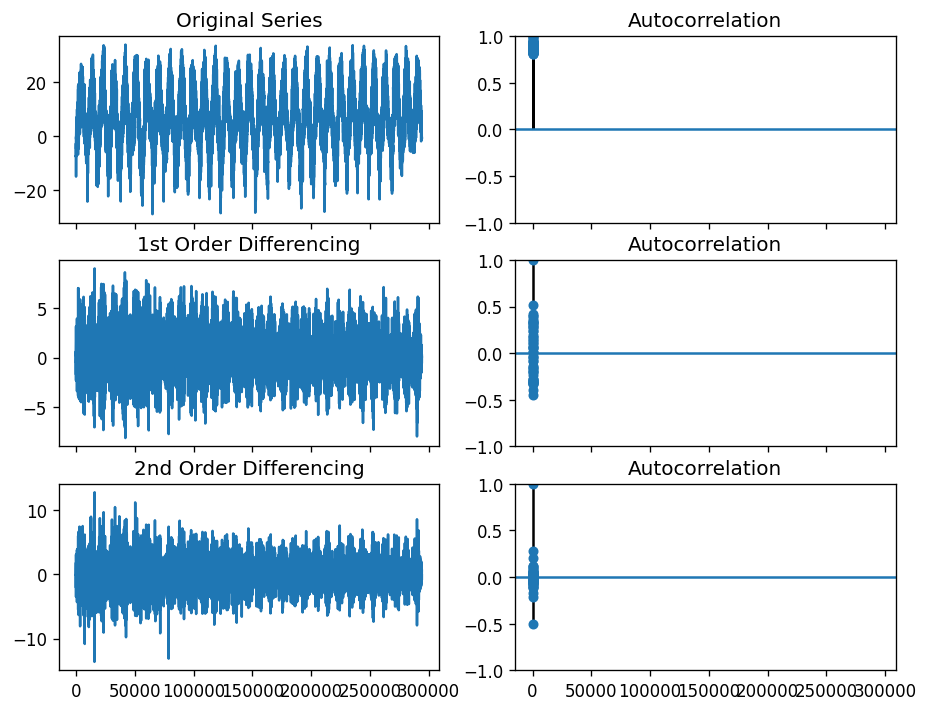

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(temp); axes[0, 0].set_title('Original Series')
plot_acf(temp, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(temp.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(temp.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(temp.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(temp.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


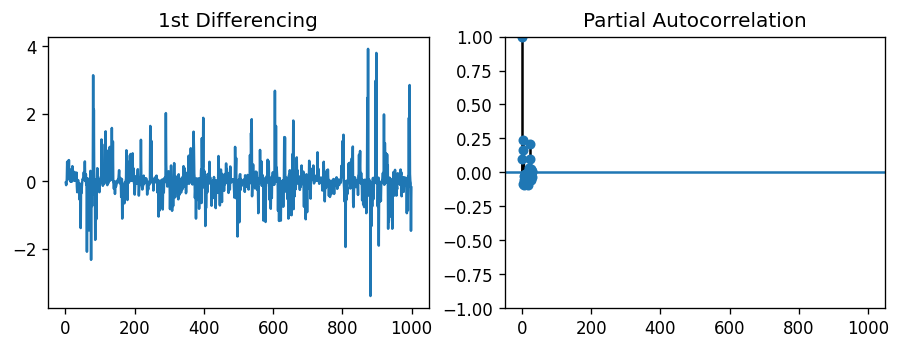

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(temp.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(temp.diff().dropna(), ax=axes[1])

plt.show()

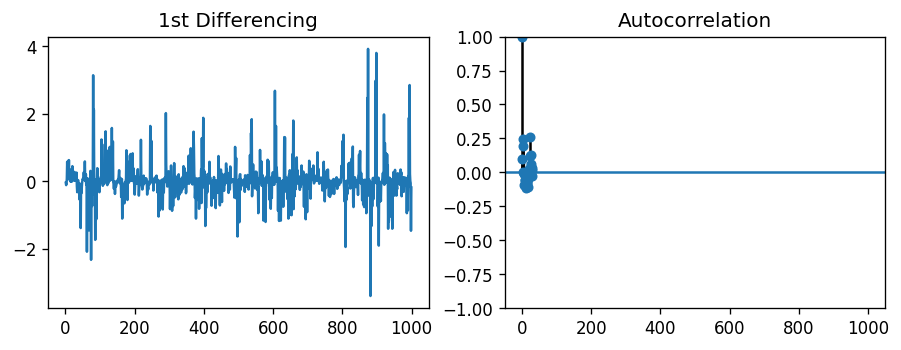

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(temp.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(temp.diff().dropna(), ax=axes[1])

plt.show()


In [ ]:
train, test = model_selection.train_test_split(d.temp, train_size=0.9)
#train = temp[:39999]
#test = temp[40000:59999]

In [ ]:
auto_arima_fit = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=3, max_q=3, max_P=3, max_Q=3, seasonal=True, trace=True,
                     stepwise=True, suppress_warnings=True, d=0, D=0, m = 12,
                     error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2343.334, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1937.767, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2524.380, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2073.711, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1847.012, Time=0.95 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.45 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=1811.502, Time=2.70 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=1543.897, Time=8.93 sec
 ARIMA(0,0,1)(2,0,3)[12] intercept   : AIC=inf, Time=17.58 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=4.40 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=1590.401, Time=9.65 sec
 ARIMA(1,0,1)(1,0,3)[12] intercept   : AIC=1544.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(train,order=(0, 0, 1), seasonal_order=(1, 0, 3, 12))
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: ignored

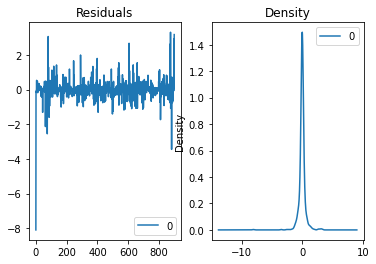

In [ ]:
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

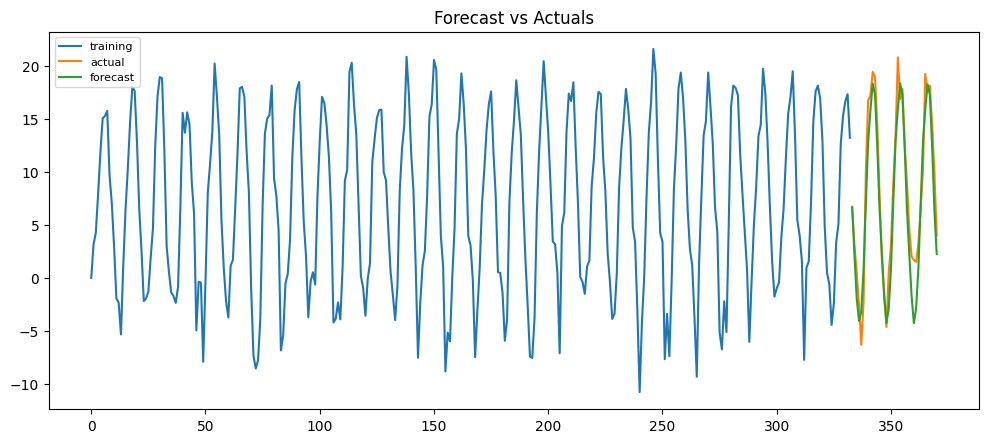

In [ ]:
forecasts = results.forecast(test.shape[0], alpha=0.05)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecasts, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Sequence Prediction

In [ ]:
# Number of lags (hours back) to use for models
lag = 168

# Steps ahead to forecast 
n_ahead = 24

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [ ]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

In [ ]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)
model.model.summary()

In [ ]:
history = model.train()

In [ ]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Forecasting on all the samples in the validation set 
forecast = model.predict(Xval)


In [ ]:
# Calculating the total average absolute error 
error = 0 
n = 0
residuals = []

for i in range(Yval.shape[0]):
    true = Yval[i]
    hat = forecast[i]
    n += len(true)
    
    true = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in true])
    hat = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in hat])
    
    residual = true - hat
    residuals.append(residual)
    
    error += np.sum([abs(x) for x in true - hat]) 

print(f'Final average absolute error: {round(error / n, 2)} C')

# Flattening the list of arrays of residuals
residuals = np.asarray(residuals).flatten().tolist()
abs_residuals = [abs(x) for x in residuals]

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(abs_residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast - absolute')
plt.show()